In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from dataset import NASBench101Dataset

### Load dataset

In [3]:
build_size = 2000 
train_size = build_size * 0.8
dataset = NASBench101Dataset('data/nasbench101.hdf5', str(build_size)) 
dataset_all = NASBench101Dataset('data/nasbench101.hdf5', "all")

In [88]:
print(dataset[42])

{'num_vertices': 7, 'trainable_parameters': 7681802, 'adjacency': (array([[0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 1, 1, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0]], dtype=int8),), 'operations': array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32), 'mask': array([1., 1., 1., 1., 1., 1., 1.], dtype=float32), 'val_acc': 0.90905446, 'test_acc': 0.9050481, 'depth': 5, 'num_connections': 9, 'avg_connections_per_vertex': 1.2857142857142858, 'conv3x3_count': 3.0, 'conv1x1_count': 1.0, 'maxpool3x3_count': 1.0, 'training_time': 1509.833}


### Feature extraction

In [4]:
from utils import get_targets, get_flat_features, get_flat_features_boosted, get_gcn_features 

In [5]:
# Get train data features and targets
predictor_build_features = get_flat_features(dataset)
predictor_build_targets = get_targets(dataset)

# Get extended train data features (additional features) 
predictor_build_features_ext = get_flat_features_boosted(dataset)

# Get data for applying predictors
all_features = get_flat_features(dataset_all)
all_features_ext = get_flat_features_boosted(dataset_all)
all_targets = get_targets(dataset_all)

In [89]:
print(predictor_build_features.shape)

(2000, 84)


In [6]:
from sklearn.model_selection import train_test_split

# Divide features into train and test sets
train_features, test_features, train_targets, test_targets = train_test_split(
    predictor_build_features, predictor_build_targets, test_size=0.2, random_state=42
)

train_features_ext, test_features_ext, train_targets_ext, test_targets_ext = train_test_split(
    predictor_build_features_ext, predictor_build_targets, test_size=0.2, random_state=42
)

**Get 100k NAS-Bench-101 subset**

In [7]:
# Get subset random samples from the dataset
subset = 100_000
indices = np.random.choice(all_features.shape[0], subset, replace=False)

features_100k = all_features[indices]
features_100k_ext = all_features_ext[indices]
targets_100k = all_targets[indices]

## Training the predictors

In [8]:
from utils import measure_training_time

### Linear regression predictor (`LRPredictor`)

In [9]:
from predictors.linear_regression import LRPredictor

lr_predictor = LRPredictor()
train_time = measure_training_time(lr_predictor, train_features, train_targets, num_runs=3)


print(f"LR - Training time ({len(train_features)} samples): {train_time:.2f}s")

LR - Training time (1600 samples): 0.02s


**Extended features**

In [10]:
lr_predictor_ext = LRPredictor()
train_time_ext = measure_training_time(lr_predictor_ext, train_features_ext, train_targets_ext, num_runs=3)

print(f"LR - Training time ({len(train_features_ext)} samples) for extended features: {train_time_ext:.2f}s")

LR - Training time (1600 samples) for extended features: 0.02s


### Random forest predictor (`RFPredictor`)

In [11]:
from predictors.random_forest import RFPredictor

rf_predictor = RFPredictor()
train_time = measure_training_time(rf_predictor, train_features, train_targets, num_runs=3)

print(f"RF - Training time ({len(train_features)} samples): {train_time:.2f}s")

RF - Training time (1600 samples): 0.30s


**Extended features**

In [12]:
rf_predictor_ext = RFPredictor()
train_time_ext = measure_training_time(rf_predictor_ext, train_features_ext, train_targets_ext, num_runs=3)

print(f"RF - Training time ({len(train_features_ext)} samples) for extended features: {train_time_ext:.2f}s")

RF - Training time (1600 samples) for extended features: 0.33s


### XGBoost predictor

In [13]:
from predictors.xgb import XGBPredictor

xgb_predictor = XGBPredictor()
train_time = measure_training_time(xgb_predictor, train_features, train_targets, num_runs=3)

print(f"XGB - Training time ({len(train_features)} samples): {train_time:.2f}s")

XGB - Training time (1600 samples): 0.17s


**Extended features**

In [14]:
xgb_predictor_ext = XGBPredictor()
train_time_ext = measure_training_time(xgb_predictor_ext, train_features_ext, train_targets_ext, num_runs=3)

print(f"XGB - Training time ({len(train_features_ext)} samples) for extended features: {train_time_ext:.2f}s")

XGB - Training time (1600 samples) for extended features: 0.19s


### MLP predictor (`MLPPredictor`)

In [15]:
from predictors.mlp import MLPPredictor


mlp_predictor = MLPPredictor()
train_time = measure_training_time(mlp_predictor, train_features, train_targets, num_runs=3)

print(f"MLP - Training time ({len(train_features)} samples): {train_time:.2f}s")

[05/15 11:37:38] INFO (root) Epoch 1/500, Loss: 2.2187
[05/15 11:37:38] INFO (root) Epoch 2/500, Loss: 1.8628
[05/15 11:37:38] INFO (root) Epoch 3/500, Loss: 1.4971
[05/15 11:37:38] INFO (root) Epoch 4/500, Loss: 1.2337
[05/15 11:37:39] INFO (root) Epoch 5/500, Loss: 1.0813
[05/15 11:37:39] INFO (root) Epoch 6/500, Loss: 0.9200
[05/15 11:37:39] INFO (root) Epoch 7/500, Loss: 0.8119
[05/15 11:37:40] INFO (root) Epoch 8/500, Loss: 0.6906
[05/15 11:37:40] INFO (root) Epoch 9/500, Loss: 0.6313
[05/15 11:37:40] INFO (root) Epoch 10/500, Loss: 0.5124
[05/15 11:37:40] INFO (root) Epoch 11/500, Loss: 0.4839
[05/15 11:37:41] INFO (root) Epoch 12/500, Loss: 0.4412
[05/15 11:37:41] INFO (root) Epoch 13/500, Loss: 0.4039
[05/15 11:37:41] INFO (root) Epoch 14/500, Loss: 0.3996
[05/15 11:37:41] INFO (root) Epoch 15/500, Loss: 0.3835
[05/15 11:37:42] INFO (root) Epoch 16/500, Loss: 0.4111
[05/15 11:37:42] INFO (root) Epoch 17/500, Loss: 0.3283
[05/15 11:37:42] INFO (root) Epoch 18/500, Loss: 0.2886
[

**Extended features**

In [16]:
mlp_predictor_ext = MLPPredictor()
train_time_ext = measure_training_time(mlp_predictor_ext, train_features_ext, train_targets_ext, num_runs=3)

print(f"MLP - Training time ({len(train_features_ext)} samples) for extended features: {train_time_ext:.2f}s")

[05/15 11:45:01] INFO (root) Epoch 1/500, Loss: 2.0837
[05/15 11:45:01] INFO (root) Epoch 2/500, Loss: 1.8299
[05/15 11:45:01] INFO (root) Epoch 3/500, Loss: 1.4039
[05/15 11:45:02] INFO (root) Epoch 4/500, Loss: 1.1625
[05/15 11:45:02] INFO (root) Epoch 5/500, Loss: 0.9853
[05/15 11:45:02] INFO (root) Epoch 6/500, Loss: 0.8474
[05/15 11:45:02] INFO (root) Epoch 7/500, Loss: 0.7598
[05/15 11:45:03] INFO (root) Epoch 8/500, Loss: 0.6354
[05/15 11:45:03] INFO (root) Epoch 9/500, Loss: 0.5449
[05/15 11:45:03] INFO (root) Epoch 10/500, Loss: 0.4917
[05/15 11:45:04] INFO (root) Epoch 11/500, Loss: 0.4417
[05/15 11:45:04] INFO (root) Epoch 12/500, Loss: 0.3863
[05/15 11:45:04] INFO (root) Epoch 13/500, Loss: 0.3796
[05/15 11:45:05] INFO (root) Epoch 14/500, Loss: 0.3656
[05/15 11:45:05] INFO (root) Epoch 15/500, Loss: 0.3548
[05/15 11:45:05] INFO (root) Epoch 16/500, Loss: 0.3344
[05/15 11:45:05] INFO (root) Epoch 17/500, Loss: 0.3166
[05/15 11:45:06] INFO (root) Epoch 18/500, Loss: 0.2816
[

### GCN predictor (`GCNPredictor`)

In [17]:
# TODO: necessary?
features_gcn = np.array(list([a for a in dataset]))
all_features_gcn = np.array(list([a for a in dataset_all]))

# For applying GCN predictor
features_gcn_100k = all_features_gcn[indices] # subset of nasbench101

In [18]:
train_features_gcn, test_features_gcn, train_targets_gcn, test_targets_gcn = train_test_split(
    features_gcn, predictor_build_targets, test_size=0.2, random_state=42
)

In [19]:
from predictors.gcn import GCNPredictor

gcn_predictor = GCNPredictor()
train_time = measure_training_time(gcn_predictor, train_features_gcn, train_targets_gcn, num_runs=3)

print(f"GCN - Training time ({len(train_features)} samples): {train_time:.2f}s")

c:\Users\simon\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\_utils\collate.py:176: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:233.)
  return torch.as_tensor(batch)


[05/15 11:52:49] INFO (root) Epoch 1/300, Loss: 0.9919, MSE: 7.1749
[05/15 11:52:51] INFO (root) Epoch 2/300, Loss: 0.9376, MSE: 6.7827
[05/15 11:52:52] INFO (root) Epoch 3/300, Loss: 0.8523, MSE: 6.1653
[05/15 11:52:54] INFO (root) Epoch 4/300, Loss: 0.7987, MSE: 5.7777
[05/15 11:52:55] INFO (root) Epoch 5/300, Loss: 0.7590, MSE: 5.4904
[05/15 11:52:57] INFO (root) Epoch 6/300, Loss: 0.7295, MSE: 5.2770
[05/15 11:52:59] INFO (root) Epoch 7/300, Loss: 0.7046, MSE: 5.0966
[05/15 11:53:00] INFO (root) Epoch 8/300, Loss: 0.6824, MSE: 4.9363
[05/15 11:53:02] INFO (root) Epoch 9/300, Loss: 0.6631, MSE: 4.7965
[05/15 11:53:03] INFO (root) Epoch 10/300, Loss: 0.6463, MSE: 4.6749
[05/15 11:53:05] INFO (root) Epoch 11/300, Loss: 0.6293, MSE: 4.5520
[05/15 11:53:06] INFO (root) Epoch 12/300, Loss: 0.6135, MSE: 4.4382
[05/15 11:53:08] INFO (root) Epoch 13/300, Loss: 0.5987, MSE: 4.3306
[05/15 11:53:10] INFO (root) Epoch 14/300, Loss: 0.5853, MSE: 4.2339
[05/15 11:53:11] INFO (root) Epoch 15/300, 

## Predictor Evaluation

### Test sets

In [20]:
# Collect this data - later create latex table
all_models, all_metrics = [], []

In [21]:
# LR metrics
lr_metrics = lr_predictor.evaluate(test_features, test_targets)
all_models.append("Linear Regression")
all_metrics.append(lr_metrics)

print(f"LR - Test metrics: {lr_metrics}")

LR - Test metrics: {'rmse': 0.01796027019610466, 'mae': 0.01131201520562172, 'mse': 0.00032257130551708533, 'pearson': 0.7156838122399101, 'spearman': 0.8183457450817804, 'kendalltau': 0.6264423717608452, 'r2_score': 0.5107164343645887}


In [22]:
## RF metrics
rf_metrics = rf_predictor.evaluate(test_features, test_targets)
all_models.append("Random Forest")
all_metrics.append(rf_metrics)

print(f"RF - Test metrics: {rf_metrics}")

RF - Test metrics: {'rmse': 0.012796437158900983, 'mae': 0.008880692029023864, 'mse': 0.0001637488039617019, 'pearson': 0.8964392319911219, 'spearman': 0.8948630510280201, 'kendalltau': 0.7187120029270381, 'r2_score': 0.7516220528590326}


In [23]:
## XGB metrics
xgb_metrics = xgb_predictor.evaluate(test_features, test_targets)
all_models.append("XGBoost")
all_metrics.append(xgb_metrics)

print(f"XGB - Test metrics: {xgb_metrics}")

XGB - Test metrics: {'rmse': 0.012022618527659505, 'mae': 0.007993201017379761, 'mse': 0.00014454335626162162, 'pearson': 0.8875564191028807, 'spearman': 0.8949301769132444, 'kendalltau': 0.7215462682721238, 'r2_score': 0.780753317077517}


In [24]:
## MLP metrics
mlp_metrics = mlp_predictor.evaluate(test_features, test_targets)
all_models.append("MLP")
all_metrics.append(mlp_metrics)

print(f"MLP - Test metrics: {mlp_metrics}")

MLP - Test metrics: {'rmse': 0.012508817860304871, 'mae': 0.008894648253917694, 'mse': 0.00015647052426228213, 'pearson': 0.874926234812401, 'spearman': 0.853584749805938, 'kendalltau': 0.666633418876021, 'r2_score': 0.7626619146883896}


In [25]:
## GCN metrics
gcn_metrics = gcn_predictor.evaluate(test_features_gcn, test_targets_gcn)
all_models.append("GCN")
all_metrics.append(gcn_metrics)

print(f"GCN - Test metrics: {gcn_metrics}")

GCN - Test metrics: {'rmse': 0.01023663444424358, 'mae': 0.006891073882579804, 'mse': 0.00010478868474507408, 'pearson': 0.9175671337460891, 'spearman': 0.9150531297851696, 'kendalltau': 0.7465530164938082, 'r2_score': 0.8410541159942101}


### 100k set basic

In [26]:
from utils import measure_query_time

In [27]:
# Collect this data - later create latex table
all_models_100k, all_metrics_100k = [], []

In [28]:
# LR metrics
prediction_time = measure_query_time(lr_predictor, features_100k, targets_100k, num_runs=3)

lr_metrics = lr_predictor.evaluate(features_100k, targets_100k)
lr_metrics = {k: round(v, 5) for k, v in lr_metrics.items()}
all_models_100k.append("Linear Regression")
all_metrics_100k.append(lr_metrics)

print(lr_metrics)
print(f"LR - Prediction time ({len(features_100k)}) samples): {prediction_time:.2f}s")

{'rmse': 13.43798, 'mae': 0.08579, 'mse': 180.57931, 'pearson': -0.00149, 'spearman': 0.78576, 'kendalltau': 0.59204, 'r2_score': -210876.45558}
LR - Prediction time (100000) samples): 0.02s


In [29]:
# RF metrics
prediction_time = measure_query_time(rf_predictor, features_100k, targets_100k, num_runs=3)

rf_metrics = rf_predictor.evaluate(features_100k, targets_100k)
rf_metrics = {k: round(v, 5) for k, v in rf_metrics.items()}
all_models_100k.append("Random Forest")
all_metrics_100k.append(rf_metrics)

print(rf_metrics)
print(f"RF - Prediction time ({len(features_100k)}) samples): {prediction_time:.2f}s")

{'rmse': 0.01783, 'mae': 0.00963, 'mse': 0.00032, 'pearson': 0.82732, 'spearman': 0.86907, 'kendalltau': 0.68517, 'r2_score': 0.62869}
RF - Prediction time (100000) samples): 1.13s


In [30]:
# XGB metrics
prediction_time = measure_query_time(xgb_predictor, features_100k, targets_100k, num_runs=3)

xgb_metrics = xgb_predictor.evaluate(features_100k, targets_100k)
xgb_metrics = {k: round(v, 5) for k, v in xgb_metrics.items()}
all_models_100k.append("XGBoost")
all_metrics_100k.append(xgb_metrics)

print(xgb_metrics)
print(f"XGB - Prediction time ({len(features_100k)}) samples): {prediction_time:.2f}s")

{'rmse': 0.01551, 'mae': 0.00864, 'mse': 0.00024, 'pearson': 0.84826, 'spearman': 0.88028, 'kendalltau': 0.7016, 'r2_score': 0.7192}
XGB - Prediction time (100000) samples): 0.05s


In [31]:
# MLP metrics
prediction_time = measure_query_time(mlp_predictor, features_100k, targets_100k, num_runs=3)

mlp_metrics = mlp_predictor.evaluate(features_100k, targets_100k)
mlp_metrics = {k: round(v, 5) for k, v in mlp_metrics.items()}
all_models_100k.append("MLP")
all_metrics_100k.append(mlp_metrics)

print(mlp_metrics)
print(f"MLP - Prediction time ({len(features_100k)}) samples): {prediction_time:.2f}s")

{'rmse': 0.01669, 'mae': 0.00975, 'mse': 0.00028, 'pearson': 0.8227, 'spearman': 0.8501, 'kendalltau': 0.66078, 'r2_score': 0.67453}
MLP - Prediction time (100000) samples): 1.15s


**Print results**

In [51]:
print(all_models_100k)
print(all_metrics_100k)
create_latex_table(all_metrics_100k, all_models_100k)

['Linear Regression', 'Random Forest', 'XGBoost', 'MLP']
[{'rmse': 13.43798, 'mae': 0.08579, 'mse': 180.57931, 'pearson': -0.00149, 'spearman': 0.78576, 'kendalltau': 0.59204, 'r2_score': -210876.45558}, {'rmse': 0.01783, 'mae': 0.00963, 'mse': 0.00032, 'pearson': 0.82732, 'spearman': 0.86907, 'kendalltau': 0.68517, 'r2_score': 0.62869}, {'rmse': 0.01551, 'mae': 0.00864, 'mse': 0.00024, 'pearson': 0.84826, 'spearman': 0.88028, 'kendalltau': 0.7016, 'r2_score': 0.7192}, {'rmse': 0.01669, 'mae': 0.00975, 'mse': 0.00028, 'pearson': 0.8227, 'spearman': 0.8501, 'kendalltau': 0.66078, 'r2_score': 0.67453}]


"\\begin{table}[h]\n\\centering\n\\caption{Performance Metrics of Predictors with Basic Feature Set}\n    \\begin{tabular}{lccccc}\n    \\hline\n    \\textbf{Predictor} & \\textbf{MSE} & \\textbf{MAE} & \\textbf{Pearson} & \\textbf{Kendall's $\\tau$} & \\textbf{$R^2$} \\\\\n    \\hline\n    Linear Regression & 180.5793 & 0.0858 & -0.0015 & 0.5920 & -210876.4556 \\\\\n    Random Forest & 0.0003 & 0.0096 & 0.8273 & 0.6852 & 0.6287 \\\\\n    XGBoost & 0.0002 & 0.0086 & 0.8483 & 0.7016 & 0.7192 \\\\\n    MLP & 0.0003 & 0.0097 & 0.8227 & 0.6608 & 0.6745 \\\\\n    \\hline\n    \\end{tabular}\n\\label{tab:metrics_basic}\n\\end{table}"

### 100k set extended

In [34]:
# Collect this data - later create latex table
all_models_100k_ext, all_metrics_100k_ext = [], []

In [35]:
# LR metrics
prediction_time = measure_query_time(lr_predictor_ext, features_100k_ext, targets_100k, num_runs=3)

lr_metrics = lr_predictor_ext.evaluate(features_100k_ext, targets_100k)
lr_metrics = {k: round(v, 5) for k, v in lr_metrics.items()}
all_models_100k_ext.append("Linear Regression")
all_metrics_100k_ext.append(lr_metrics)

print(lr_metrics)
print(f"LR - Prediction time ({len(features_100k)}) samples): {prediction_time:.2f}s")

{'rmse': 1193336165.08616, 'mae': 6538555.13899, 'mse': 1.4240512029025354e+18, 'pearson': -0.00236, 'spearman': -0.33467, 'kendalltau': -0.20082, 'r2_score': -1.6629828759296564e+21}
LR - Prediction time (100000) samples): 0.01s


In [36]:
# RF metrics
prediction_time = measure_query_time(rf_predictor_ext, features_100k_ext, targets_100k, num_runs=3)

rf_metrics = rf_predictor_ext.evaluate(features_100k_ext, targets_100k)
rf_metrics = {k: round(v, 5) for k, v in rf_metrics.items()}
all_models_100k_ext.append("Random Forest")
all_metrics_100k_ext.append(rf_metrics)

print(rf_metrics)
print(f"RF - Prediction time ({len(features_100k)}) samples) for extended features: {prediction_time:.2f}s")

{'rmse': 0.01763, 'mae': 0.00927, 'mse': 0.00031, 'pearson': 0.81183, 'spearman': 0.88165, 'kendalltau': 0.69971, 'r2_score': 0.63709}
RF - Prediction time (100000) samples) for extended features: 1.23s


In [40]:
# XGB metrics
prediction_time = measure_query_time(xgb_predictor_ext, features_100k_ext, targets_100k, num_runs=3)

xgb_metrics = xgb_predictor_ext.evaluate(features_100k_ext, targets_100k)
xgb_metrics = {k: round(v, 5) for k, v in xgb_metrics.items()}
all_models_100k_ext.append("XGBoost")
all_metrics_100k_ext.append(xgb_metrics)

print(xgb_metrics)
print(f"XGB - Prediction time ({len(features_100k)}) samples) for extended features: {prediction_time:.2f}s")

{'rmse': 0.01728, 'mae': 0.00869, 'mse': 0.0003, 'pearson': 0.80737, 'spearman': 0.8915, 'kendalltau': 0.71376, 'r2_score': 0.65144}
XGB - Prediction time (100000) samples) for extended features: 0.05s


In [42]:
# MLP metrics
prediction_time = measure_query_time(mlp_predictor_ext, features_100k_ext, targets_100k, num_runs=3)

mlp_metrics = mlp_predictor_ext.evaluate(features_100k_ext, targets_100k)
mlp_metrics = {k: round(v, 5) for k, v in mlp_metrics.items()}
all_models_100k_ext.append("MLP")
all_metrics_100k_ext.append(mlp_metrics)

print(mlp_metrics)
print(f"MLP - Prediction time ({len(features_100k)}) samples) for extended features: {prediction_time:.2f}s")

{'rmse': 0.01741, 'mae': 0.0106, 'mse': 0.0003, 'pearson': 0.80908, 'spearman': 0.82071, 'kendalltau': 0.62885, 'r2_score': 0.646}
MLP - Prediction time (100000) samples) for extended features: 1.37s


In [44]:
# GCN metrics
prediction_time = measure_query_time(gcn_predictor, features_gcn_100k, targets_100k, num_runs=3)

gcn_metrics = gcn_predictor.evaluate(features_gcn_100k, targets_100k)
gcn_metrics = {k: round(v, 5) for k, v in gcn_metrics.items()}
all_models_100k_ext.append("GCN")
all_metrics_100k_ext.append(gcn_metrics)

print(gcn_metrics)
print(f"GCN - Prediction time ({len(features_gcn_100k)}) samples): {prediction_time:.2f}s")

{'rmse': 0.01398, 'mae': 0.00755, 'mse': 0.0002, 'pearson': 0.88015, 'spearman': 0.90337, 'kendalltau': 0.73522, 'r2_score': 0.77193}
GCN - Prediction time (100000) samples): 3.16s


**Print results**

In [47]:
from utils import create_latex_table

In [50]:
print(all_models_100k_ext)
print(all_metrics_100k_ext)
create_latex_table(all_metrics_100k_ext, all_models_100k_ext)

['Linear Regression', 'Random Forest', 'XGBoost', 'XGBoost', 'XGBoost', 'XGBoost', 'MLP', 'GCN', 'GCN']
[{'rmse': 1193336165.08616, 'mae': 6538555.13899, 'mse': 1.4240512029025354e+18, 'pearson': -0.00236, 'spearman': -0.33467, 'kendalltau': -0.20082, 'r2_score': -1.6629828759296564e+21}, {'rmse': 0.01763, 'mae': 0.00927, 'mse': 0.00031, 'pearson': 0.81183, 'spearman': 0.88165, 'kendalltau': 0.69971, 'r2_score': 0.63709}, {'rmse': 0.01728, 'mae': 0.00869, 'mse': 0.0003, 'pearson': 0.80737, 'spearman': 0.8915, 'kendalltau': 0.71376, 'r2_score': 0.65144}, {'rmse': 0.01728, 'mae': 0.00869, 'mse': 0.0003, 'pearson': 0.80737, 'spearman': 0.8915, 'kendalltau': 0.71376, 'r2_score': 0.65144}, {'rmse': 0.01728, 'mae': 0.00869, 'mse': 0.0003, 'pearson': 0.80737, 'spearman': 0.8915, 'kendalltau': 0.71376, 'r2_score': 0.65144}, {'rmse': 0.01728, 'mae': 0.00869, 'mse': 0.0003, 'pearson': 0.80737, 'spearman': 0.8915, 'kendalltau': 0.71376, 'r2_score': 0.65144}, {'rmse': 0.01741, 'mae': 0.0106, 'mse'

"\\begin{table}[h]\n\\centering\n\\caption{Performance Metrics of Predictors with Basic Feature Set}\n    \\begin{tabular}{lccccc}\n    \\hline\n    \\textbf{Predictor} & \\textbf{MSE} & \\textbf{MAE} & \\textbf{Pearson} & \\textbf{Kendall's $\\tau$} & \\textbf{$R^2$} \\\\\n    \\hline\n    Linear Regression & 1424051202902535424.0000 & 6538555.1390 & -0.0024 & -0.2008 & -1662982875929656426496.0000 \\\\\n    Random Forest & 0.0003 & 0.0093 & 0.8118 & 0.6997 & 0.6371 \\\\\n    XGBoost & 0.0003 & 0.0087 & 0.8074 & 0.7138 & 0.6514 \\\\\n    XGBoost & 0.0003 & 0.0087 & 0.8074 & 0.7138 & 0.6514 \\\\\n    XGBoost & 0.0003 & 0.0087 & 0.8074 & 0.7138 & 0.6514 \\\\\n    XGBoost & 0.0003 & 0.0087 & 0.8074 & 0.7138 & 0.6514 \\\\\n    MLP & 0.0003 & 0.0106 & 0.8091 & 0.6289 & 0.6460 \\\\\n    GCN & 0.0002 & 0.0076 & 0.8801 & 0.7352 & 0.7719 \\\\\n    GCN & 0.0002 & 0.0076 & 0.8801 & 0.7352 & 0.7719 \\\\\n    \\hline\n    \\end{tabular}\n\\label{tab:metrics_basic}\n\\end{table}"

## Apply the predictors

In [52]:
from utils import scatter_plot_nice

In [53]:
targets_100k_scaled = targets_100k * 100

### Linear regression predictor

In [54]:
lr_predictions = lr_predictor.predict(features_100k)
lr_predictions_scaled = lr_predictions * 100

In [55]:
# Print number of predictions outside of [0, 100]
print("Number of predictions outside of [0, 100]: " + str(len(lr_predictions_scaled[(lr_predictions_scaled < 0) | (lr_predictions_scaled > 100)])))

Number of predictions outside of [0, 100]: 3


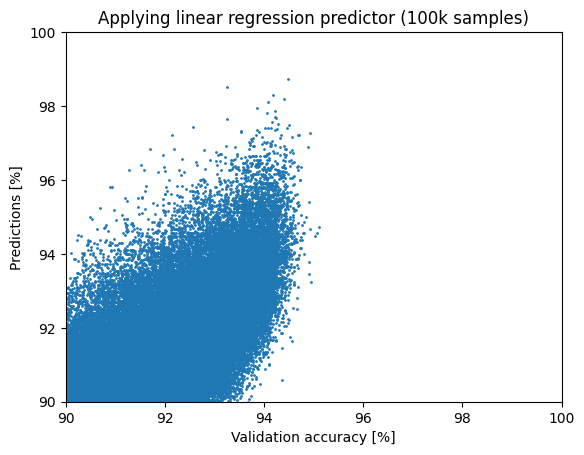

In [56]:
plt.scatter(targets_100k_scaled, lr_predictions_scaled, s=1)
plt.xlabel("Validation accuracy [%]")
plt.ylabel("Predictions [%]")
plt.xlim(90, 100)
plt.ylim(90, 100)
plt.title("Applying linear regression predictor (100k samples)")
plt.savefig("imgs/lr_train1600.pdf")
plt.show()

In [57]:
lr_predictions_ext = lr_predictor_ext.predict(features_100k_ext)
lr_predictions_scaled_ext = lr_predictions_ext * 100

In [58]:
# Count predictions outside of [0, 100]
lr_predictions_ext_outside = np.count_nonzero((lr_predictions_scaled_ext < 0) | (lr_predictions_scaled_ext > 100))
print(f"Predictions outside of [0, 100]: {lr_predictions_ext_outside}")

Predictions outside of [0, 100]: 100000


### Random forest predictor

In [60]:
rf_predictions = rf_predictor.predict(features_100k)
rf_predictions_scaled = rf_predictions * 100

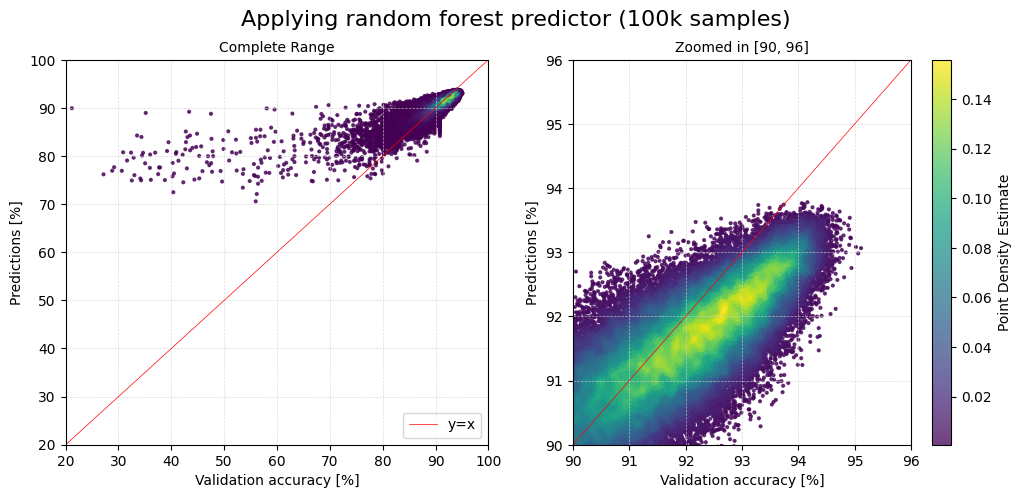

In [61]:

scatter_plot_nice(targets_100k_scaled, rf_predictions_scaled, "Applying random forest predictor (100k samples)", dense=True, save=True, filename="rf_train1600.pdf")

In [62]:
rf_predictions_ext = rf_predictor_ext.predict(features_100k_ext)
rf_predictions_scaled_ext = rf_predictions_ext * 100

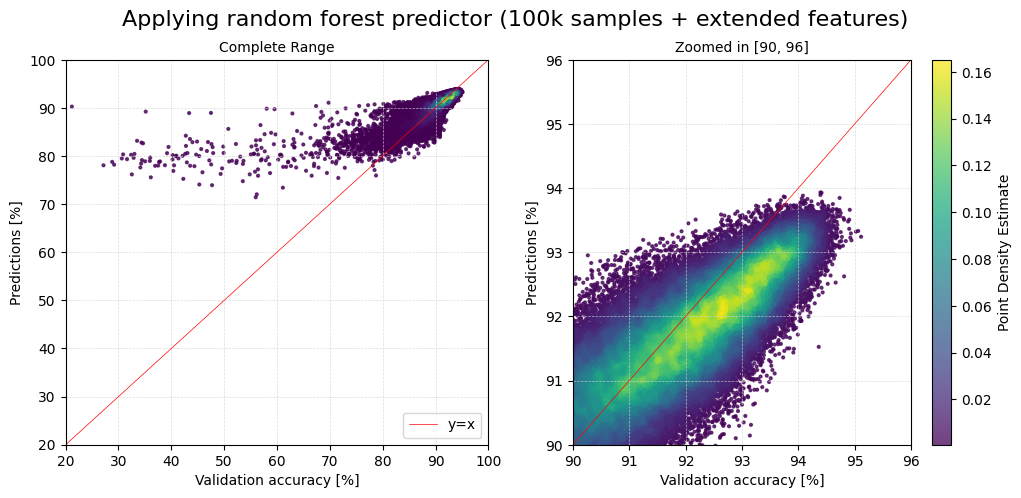

In [63]:
scatter_plot_nice(targets_100k_scaled, rf_predictions_scaled_ext, "Applying random forest predictor (100k samples + extended features)", dense=True, save=True, filename="rf_train1600ext.pdf")

### XGBoost predictor

In [64]:
xgb_predictions = xgb_predictor.predict(features_100k)
xgb_predictions_scaled = xgb_predictions * 100

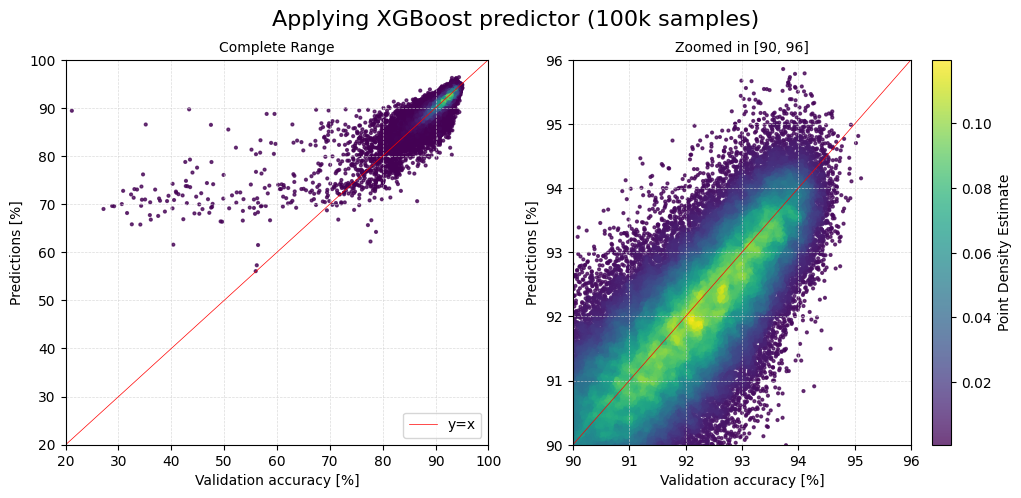

In [65]:

scatter_plot_nice(targets_100k_scaled, xgb_predictions_scaled, "Applying XGBoost predictor (100k samples)", dense=True, save=True, filename="xgb_train1600.pdf")

In [66]:
xgb_predictions_ext = xgb_predictor_ext.predict(features_100k_ext)
xgb_predictions_scaled_ext = xgb_predictions_ext * 100

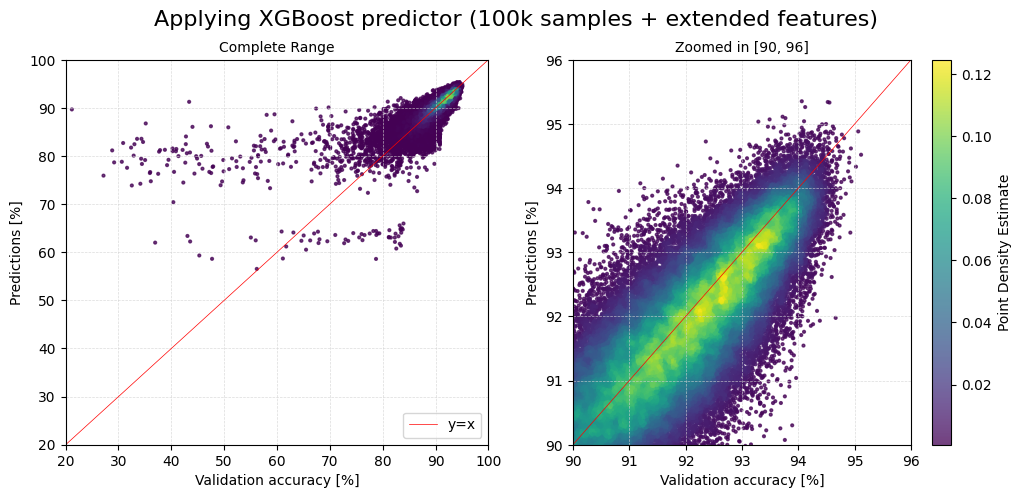

In [67]:
scatter_plot_nice(targets_100k_scaled, xgb_predictions_scaled_ext, "Applying XGBoost predictor (100k samples + extended features)", dense=True, save=True, filename="xgb_train1600ext.pdf")

### MLP predictor

In [68]:
mlp_predictions = mlp_predictor.predict(features_100k)
mlp_predictions_scaled = mlp_predictions * 100

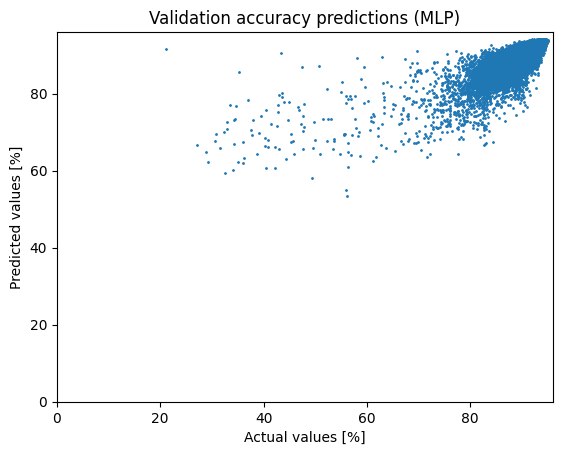

In [69]:
plt.scatter(targets_100k_scaled, mlp_predictions_scaled, s=1)
plt.xlabel("Actual values [%]")
plt.ylabel("Predicted values [%]")
plt.title("Validation accuracy predictions (MLP)")
plt.xlim(0, 96)
plt.ylim(0, 96)
plt.show()

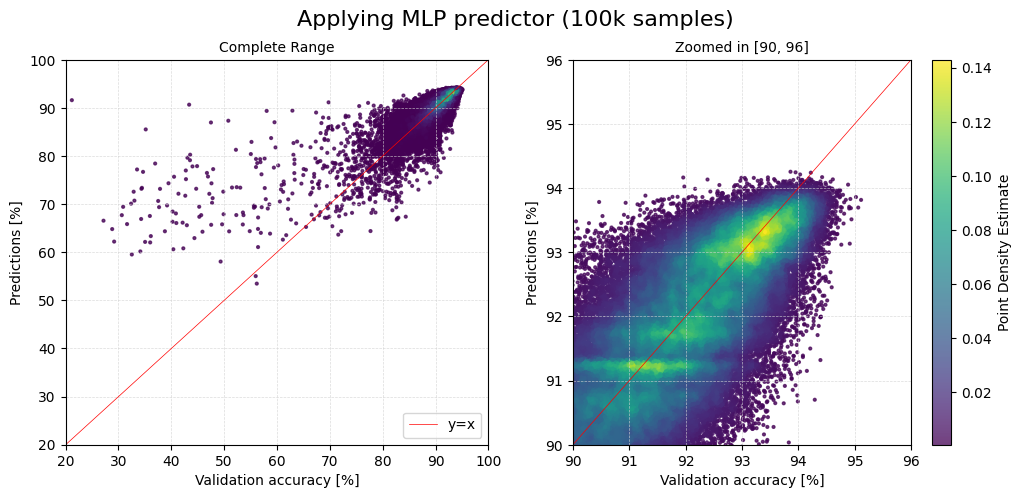

In [70]:
scatter_plot_nice(targets_100k_scaled, mlp_predictions_scaled, "Applying MLP predictor (100k samples)", dense=True, save=True, filename="mlp_train1600.pdf")

In [71]:
mlp_predictions_ext = mlp_predictor_ext.predict(features_100k_ext)
mlp_predictions_scaled_ext = mlp_predictions_ext * 100

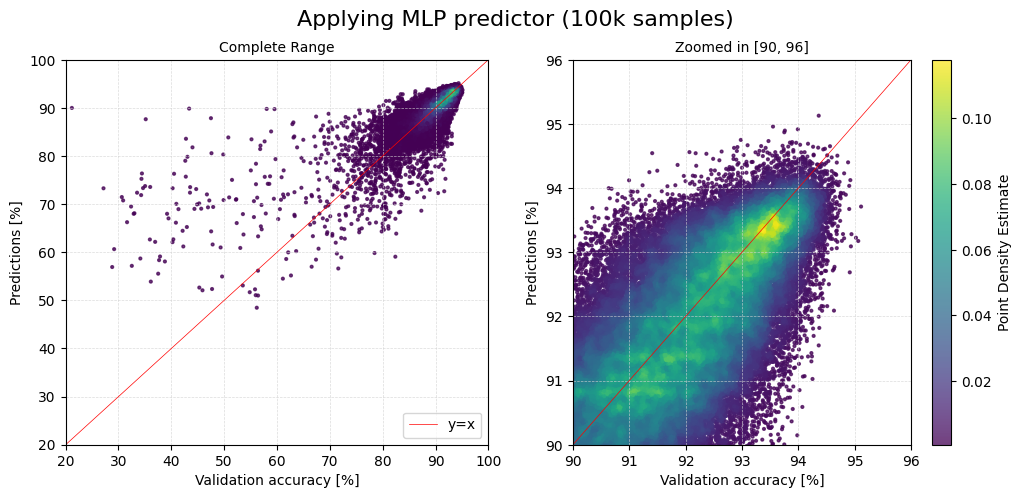

In [72]:
scatter_plot_nice(targets_100k_scaled, mlp_predictions_scaled_ext, "Applying MLP predictor (100k samples)", dense=True, save=True, filename="mlp_train1600ext.pdf")

In [73]:
from sklearn.neighbors import KernelDensity

In [74]:
cmap = 'viridis'
rf_data = np.vstack([targets_100k_scaled, rf_predictions_scaled]).T
xgb_data = np.vstack([targets_100k_scaled, xgb_predictions_scaled]).T
mlp_data = np.vstack([targets_100k_scaled, mlp_predictions_scaled]).T

rf_kde = KernelDensity(kernel='gaussian', bandwidth=0.05).fit(rf_data)
rf_z = np.exp(rf_kde.score_samples(rf_data))

xgb_kde = KernelDensity(kernel='gaussian', bandwidth=0.05).fit(xgb_data)
xgb_z = np.exp(xgb_kde.score_samples(xgb_data))

mlp_kde = KernelDensity(kernel='gaussian', bandwidth=0.05).fit(mlp_data)
mlp_z = np.exp(mlp_kde.score_samples(mlp_data))

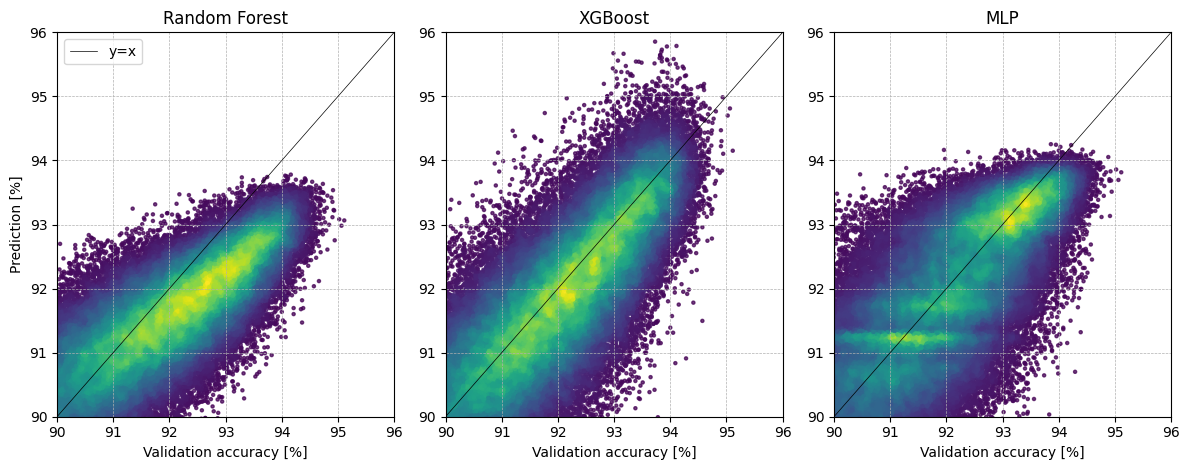

In [75]:
# Create figure (empty canvas)
fig = plt.figure()
fig.set_figwidth(12)

ax1 = fig.add_subplot(131) 
ax1.scatter(targets_100k_scaled, rf_predictions_scaled, s=5, c=rf_z, cmap=cmap, alpha=0.75)
ax1.set_title('Random Forest')
ax1.set_xlim([90, 96])
ax1.set_ylim([90, 96])
ax1.grid(linestyle='--', linewidth=0.5)
ax1.plot([90, 96], [90, 96], color='black', linestyle='-', linewidth=0.5, label='y=x')
ax1.legend()
ax1.set_xlabel("Validation accuracy [%]")
ax1.set_ylabel("Prediction [%]")

ax2 = fig.add_subplot(132) 
ax2.scatter(targets_100k_scaled, xgb_predictions_scaled, s=5, c=xgb_z, cmap=cmap, alpha=0.75)
ax2.set_title('XGBoost')
ax2.set_xlim([90, 96])
ax2.set_ylim([90, 96])
ax2.grid(linestyle='--', linewidth=0.5)
ax2.plot([90, 96], [90, 96], color='black', linestyle='-', linewidth=0.5)
ax2.set_xlabel("Validation accuracy [%]")

ax3 = fig.add_subplot(133)  
ax3.scatter(targets_100k_scaled, mlp_predictions_scaled, s=5, c=mlp_z, cmap=cmap, alpha=0.75)
ax3.set_title('MLP')   
ax3.set_xlim([90, 96])
ax3.set_ylim([90, 96])
ax3.grid(linestyle='--', linewidth=0.5)
ax3.plot([90, 96], [90, 96], color='black', linestyle='-', linewidth=0.5)
ax3.set_xlabel("Validation accuracy [%]")

# TODO: mention that colorbar was avoided for better visibility

# Adjust subplots to provide spacing
plt.tight_layout()

# Show the figure with subplots
plt.show()

### Extended features

In [76]:
cmap = 'viridis'
rf_data = np.vstack([targets_100k_scaled, rf_predictions_scaled_ext]).T
xgb_data = np.vstack([targets_100k_scaled, xgb_predictions_scaled_ext]).T
mlp_data = np.vstack([targets_100k_scaled, mlp_predictions_scaled_ext]).T

rf_kde = KernelDensity(kernel='gaussian', bandwidth=0.05).fit(rf_data)
rf_z = np.exp(rf_kde.score_samples(rf_data))

xgb_kde = KernelDensity(kernel='gaussian', bandwidth=0.05).fit(xgb_data)
xgb_z = np.exp(xgb_kde.score_samples(xgb_data))

mlp_kde = KernelDensity(kernel='gaussian', bandwidth=0.05).fit(mlp_data)
mlp_z = np.exp(mlp_kde.score_samples(mlp_data))

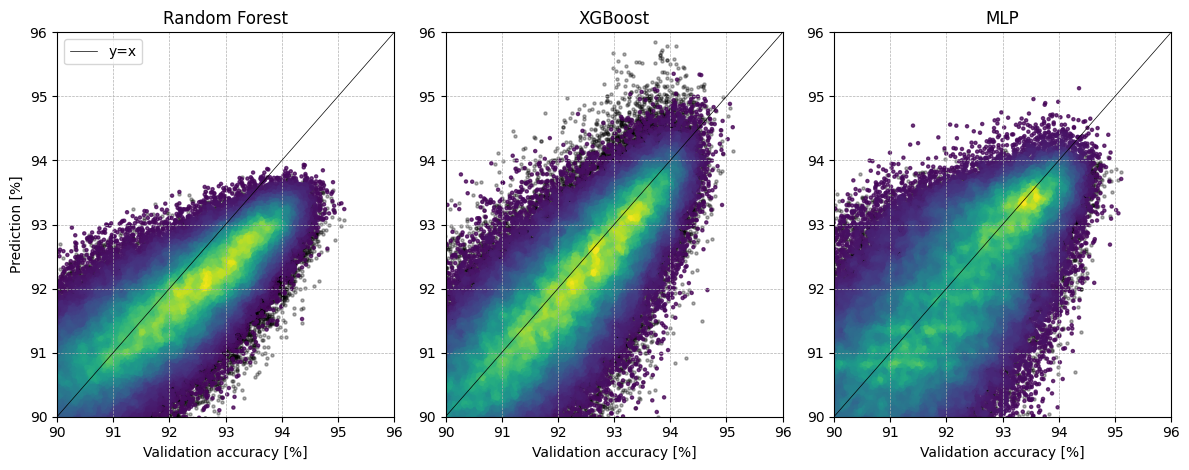

In [77]:
# Create figure (empty canvas)
fig = plt.figure()
fig.set_figwidth(12)

ax1 = fig.add_subplot(131) 
ax1.scatter(targets_100k_scaled, rf_predictions_scaled, s=5, c='black', alpha=0.3)
ax1.scatter(targets_100k_scaled, rf_predictions_scaled_ext, s=5, c=rf_z, cmap=cmap, alpha=0.75)
ax1.set_title('Random Forest')
ax1.set_xlim([90, 96])
ax1.set_ylim([90, 96])
ax1.grid(linestyle='--', linewidth=0.5)
ax1.plot([90, 96], [90, 96], color='black', linestyle='-', linewidth=0.5, label='y=x')
ax1.legend()
ax1.set_xlabel("Validation accuracy [%]")
ax1.set_ylabel("Prediction [%]")

ax2 = fig.add_subplot(132) 
ax2.scatter(targets_100k_scaled, xgb_predictions_scaled, s=5, c='black', alpha=0.3)
ax2.scatter(targets_100k_scaled, xgb_predictions_scaled_ext, s=5, c=xgb_z, cmap=cmap, alpha=0.75)
ax2.set_title('XGBoost')
ax2.set_xlim([90, 96])
ax2.set_ylim([90, 96])
ax2.grid(linestyle='--', linewidth=0.5)
ax2.plot([90, 96], [90, 96], color='black', linestyle='-', linewidth=0.5)
ax2.set_xlabel("Validation accuracy [%]")

ax3 = fig.add_subplot(133)  
ax3.scatter(targets_100k_scaled, mlp_predictions_scaled, s=5, c='black', alpha=0.3)
ax3.scatter(targets_100k_scaled, mlp_predictions_scaled_ext, s=5, c=mlp_z, cmap=cmap, alpha=0.75)
ax3.set_title('MLP')   
ax3.set_xlim([90, 96])
ax3.set_ylim([90, 96])
ax3.grid(linestyle='--', linewidth=0.5)
ax3.plot([90, 96], [90, 96], color='black', linestyle='-', linewidth=0.5)
ax3.set_xlabel("Validation accuracy [%]")

# TODO: mention that colorbar was avoided for better visibility

# Adjust subplots to provide spacing
plt.tight_layout()

# Show the figure with subplots
plt.show()

### GCN predictor

In [78]:
dataset_all = NASBench101Dataset('data/nasbench101.hdf5')
gcn_features_all = [a for a in dataset_all]
gcn_targets_all = get_targets(dataset_all)

In [79]:
gcn_predictions = gcn_predictor.predict(features_gcn_100k)
gcn_predictions_scaled = gcn_predictions * 100 

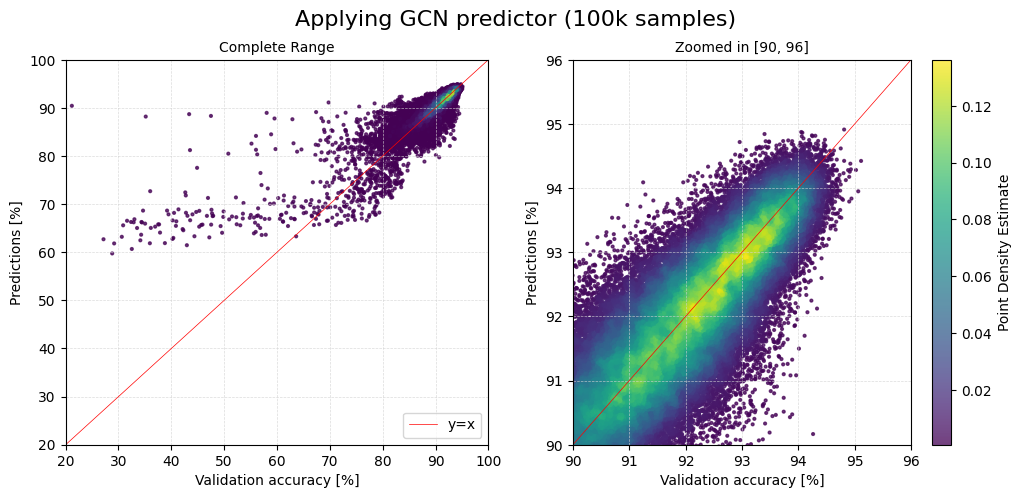

In [80]:

scatter_plot_nice(targets_100k_scaled, gcn_predictions_scaled, "Applying GCN predictor (100k samples)", dense=True, save=True, filename="gcn_train1600.pdf")

## Time speedup

In [87]:
# Get training time for CNNs in indices
# archs = [arch for arch in dataset_all]
# arch_100k = archs[indices]

training_times = [dataset_all[i]['training_time'] for i in indices]
training_times = np.array(training_times)

# Get total training time for CNNs in indices 
total_training_time_100k = training_times.sum()
print("Total training time for 100k samples: ", total_training_time_100k, " seconds")
# Print hours
print("Total training time for 100k samples: ", total_training_time_100k / 3600, " hours")
# Print days
print("Total training time for 100k samples: ", total_training_time_100k / 3600 / 24, " days")
# Print weeks
print("Total training time for 100k samples: ", total_training_time_100k / 3600 / 24 / 7, " weeks")
# Print years 
print("Total training time for 100k samples: ", total_training_time_100k / 3600 / 24 / 365, " years")
# Calculate speedup using GCN predictor
# gcn_time = gcn_init_time + gcn_predict_time
# speedup_100k = total_training_time_100k / gcn_time

Total training time for 100k samples:  193512370.0  seconds
Total training time for 100k samples:  53753.43555555555  hours
Total training time for 100k samples:  2239.726481481481  days
Total training time for 100k samples:  319.9609259259259  weeks
Total training time for 100k samples:  6.136236935565702  years
